# <center/> Kernel SVMs </center>

In this lab we'll discuss kernels and how they can be used in conjunction with support vector machines. By the end of this lab, you should know:
- What a kernel is and why we use them
- What a kernel SVM is and how to implement one

## 1 Kernels

Kernels may be intuitively thought of as similarity measures. They are functions that take two inputs from a set $\mathcal{X}$ and output a real number $\mathbb{R}$. Below are several examples.

#### 1. RBF kernel  
The radial basis function (RBF) kernel is given by
$$ k(x,y) = \exp\left(-\frac{1}{2\sigma^2}\|x-y\|^2\right),$$
where $\sigma$ is a parameter called the bandwidth that needs to be set. If we fix an element $x=1$ and picture what happens in the one-dimensional case when $\sigma=0.5$, we get the picture below:

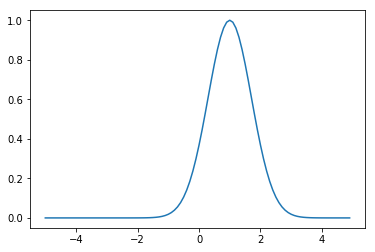

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = 1
sigma=1
y = np.arange(-5, 5, 0.1)
K = np.exp(-1/sigma**2*(x-y)**2)
plt.plot(y, K)

We can see that $k(x,y)$ is largest when $y=x$ (i.e., when they are most similar) and that as $y$ becomes farther away from $x$ the value of the $k(x,y)$ decreases.

#### 2. Hellinger kernel
The Hellinger kernel is given by $k(x,y) = \sum_{i=1}^d\sqrt{x_iy_i}$ for $x,y\in\mathbb{R}^d$ and is often used on normalized histograms. 

#### 3. A kernel for text
Let $x,x'$ be two texts. Define $\phi$ to be a mapping from a text to a vector with counts of the number of times every word in the English language appears in the text. Then $k(x,x')=\langle \phi(x), \phi(x')\rangle_\mathcal{H}$ is a kernel.

More technically, let $\mathcal{X}$ be a non-empty set. A function $k:\mathcal{X}\times\mathcal{X}\to\mathbb{R}$ is called a kernel if there exists a Hilbert space $\mathcal{H}$ and a map $\phi:\mathcal{X}\to\mathcal{H}$ such that for all $x,x'\in\mathcal{X}$,
$$ k(x,x') = \langle \phi(x), \phi(x')\rangle_\mathcal{H}.$$
The main point here is that $k$ can be written as an inner product. You can think of a kernel as preprocessing observations $x$ and $x'$ by applying $\phi$ and then taking the inner product of $\phi(x)$ and $\phi(x')$.

** Exercise 1 ** Consider the kernel $k:\mathbb{R}\times\mathbb{R}\to\mathbb{R}$ given by $k(x,x')=\sin(x)\sin(x')+x^2x'^2$. Find $\phi$ and $\phi'$. Hint: Here $\phi(x)\in\mathbb{R}^2$.

Kernel-based methods can control the smoothness of decision functions and help avoid underfitting and overfitting. Suppose a linear model is not appropriate for a given dataset. Then we could consider first applying a nonlinear function $\phi$ to the datapoints and then fitting a linear classifier on the transformed features. Unlike with other methods, with kernel methods the features generated via $\phi$ are often infinite-dimensional. While it may seem like infinite-dimensional features would be impossible to handle, if all we need is to evaluate inner products, then we can just rely on evaluating the kernel rather than ever worrying about (or even knowing) $\phi$. This will be made more concrete in the next section.

A note on terminology: Let $x_1,\dots, x_n\in\mathcal{X}$ be a set of observations and $k:\mathcal{X}\times\mathcal{X}\to\mathbb{R}$ be a kernel. The matrix given by
\begin{equation}
\begin{bmatrix}
k(x_1,x_1) & k(x_1,x_2) & \cdots & k(x_1,x_n) \\
k(x_2,x_1) & k(x_2,x_2) & \cdots & k(x_2,x_n) \\
\vdots & & \ddots & \vdots\\
k(x_n,x_1) & k(x_n,x_2) & \cdots & k(x_n,x_n)
\end{bmatrix}
\end{equation}
or alternatively written as $[k(x_i,x_j)]_{i,j=1}^n$ is called the Gram matrix and henceforth will be denoted by $K$. 

## 2 Kernel SVM

If an algorithm relies on only dot products between features, then it can be "kernelized", i.e., we can use kernels with it. This is the case for many common machine learning methods, such as ridge regression, SVMs, PCA, CCA, $k$-means,... Here we'll examine the kernel SVM. 

### 2.1 Formulation
Suppose we have inputs $x_1,\dots, x_n\in\mathbb{R}^d$ and corresponding labels $y_1,\dots, y_n\in\{-1, +1\}$. Recall that the linear SVM with the squared hinge loss is given by
$$ \min_{w\in\mathbb{R}^d} \frac{1}{n}\sum_{i=1}^n \left\{\max\left(0, 1-y_iw^Tx_i\right)\right\}^2 + \lambda\|w\|^2_2$$
or equivalently,
$$ \min_{w\in\mathbb{R}^d} \frac{1}{n}\sum_{i=1}^n \left\{\max\left(0, 1-y_i\langle w, x_i\rangle_{\mathbb{R}^d}\right)\right\}^2 + \lambda\|w\|^2_2. \hspace{3cm} \text{(1)}$$

Consider what happens if instead of directly using $x_i$ for $i=1,\dots, n$ we first apply a nonlinear mapping $\phi:\mathbb{R}^d\to\mathcal{H}$ to $x_i$ (Suppose that $\phi$ is the feature map of kernel $k$, i.e., $k(x,y) = \langle \phi(x), \phi(y)\rangle_\mathcal{H}$.). Then we could solve the following problem:
$$ \min_{f\in\mathcal{H}} \frac{1}{n}\sum_{i=1}^n \left\{\max\left(0, 1-y_i\langle f, \phi(x_i)\rangle_\mathcal{H}\right)\right\}^2 + \lambda\|f\|^2_\mathcal{H}.$$
This would be great if we could solve it because it would give us a non-linear classifier, leading to potentially better predictions. However, how can we solve this problem? And how can we predict the class of a new point?

It turns out that the solution $f$ to the above problem may be written as $f=\sum_{i=1}^n \beta_i \phi(x_i)$. With this fact in hand, we can write the problem in a more tractable form:

** Exercise 2** Let $\beta=(\beta_1, \dots, \beta_n)^T$ and $K_i=(K(x_1, x_i),K(x_2,x_i),\dots, K(x_n,x_i))^T$. Show that the above optimization problem may be rewritten as
\begin{align}
\min_{\beta\in\mathbb{R}^n} \frac{1}{n}\sum_{i=1}^n \left\{\max\left(0, 1-y_i\beta^TK_i\right)\right\}^2 + \lambda \beta^TK\beta.  \hspace{3cm} \text{(2)}
\end{align}

Note here that we're optimizing over $\beta\in\mathbb{R}^n$, i.e., the dimension of the vector we're optimizing over is the number of observations in the dataset rather than the dimension of the data.

We can optimize this objective via (fast) gradient descent. 

** Exercise 3** Compute the gradient of the objective function in equation (2).

Now we're capable of optimizing this objective function. But once we do, how do we compute the prediction for a new point $x\in\mathbb{R}^d$? Recall that in a linear SVM we label a point $x$ as +1 if $w^Tx>0$ and as -1 otherwise. Here we analogously label a point as +1 if $\langle f, \phi(x_i)\rangle_\mathcal{H}>0$ and -1 otherwise. 

** Exercise 4** Show that our prediction for a new point $x$ is $$\text{sign}\left(\sum_{i=1}^n \beta_ik(x_i, x)\right).$$

### 2.2 Do-it-yourself kernel SVM
Now we're ready to try it! We'll solve the problem using fast gradient descent.

** Exercise 5** Fill in the code the objective function for the kernel SVM given in equation (2).

In [5]:
def obj(beta, K, y, lam):
    """
    Inputs:
    - beta: Vector to be optimized
    - K: Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y: Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lam: Penalty parameter lambda
    Output:
    - Value of the objective function at beta
    """
    return np.mean(np.maximum(0, 1-y*K.dot(beta))**2) + lam*beta.dot(K).dot(beta)

** Exercise 6 ** Fill in the code for the gradient of the objective function for the kernel SVM. You derived the formula in a previous exercise. Check whether your objective function and gradient match using the code after this.

In [6]:
def grad(beta, K, y, lam):
    """
    Inputs:
    - beta: Vector to be optimized
    - K: Gram matrix consisting of evaluations of the kernel k(x_i, x_j) for i,j=1,...,n
    - y: Labels y_1,...,y_n corresponding to x_1,...,x_n
    - lam: Penalty parameter lambda
    Output:
    - Value of the gradient at beta
    """
    return -2*np.mean(np.maximum(0, 1-y*K.dot(beta))*y*K, axis=1) + 2*lam*K.dot(beta)

In [7]:
import sklearn.metrics
def test_grad(eps=1e-6):
    n = 5
    for i in range(n):
        np.random.seed(0)
        beta = -np.random.normal(size=n)
        x = np.random.randn(n, n)
        K = sklearn.metrics.pairwise.rbf_kernel(x, x)
        y = np.random.choice([0, 1], size=5)
        lam = 0.5
        f1 = obj(beta, K, y, lam)
        beta[i] = beta[i] + eps
        f2 = obj(beta, K, y, lam)
        print('Estimated and calculated values of beta[', i, ']:', (f2-f1)/eps, grad(beta, K, y, lam)[i])
        assert np.isclose((f2-f1)/eps, grad(beta, K, y, lam)[i]), 'Estimated gradient ' + str((f2-f1)/eps) + ' is not approximately equal to the computed gradient ' + str(grad(beta, K, y, lam)[i])
    print('Test passed')
  
test_grad()

Estimated and calculated values of beta[ 0 ]: -6.16205502979 -6.16205428853
Estimated and calculated values of beta[ 1 ]: -4.52475879698 -4.52475815521
Estimated and calculated values of beta[ 2 ]: -4.40740935304 -4.40740860883
Estimated and calculated values of beta[ 3 ]: -3.46901022752 -3.46900971842
Estimated and calculated values of beta[ 4 ]: -3.92967125151 -3.92967072172
Test passed


Since you've coded the fast gradient method yourself before, we will use my code for it in this lab.

In [8]:
def bt_line_search(beta, K, y, lam, eta=1, alpha=0.5, betaparam=0.8, maxiter=100):
    grad_beta = grad(beta, K, y, lam)
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_eta = 0
    iter = 0
    while found_eta == 0 and iter < maxiter:
        if obj(beta - eta * grad_beta, K, y, lam) < \
                        obj(beta, K, y, lam) - alpha * eta * norm_grad_beta ** 2:
            found_eta = 1
        elif iter == maxiter-1:
            raise ('Max number of iterations of backtracking line search reached')
        else:
            eta *= betaparam
            iter += 1
    return eta

def fastgradalgo(beta_init, theta_init, K, y, lam, eta_init, maxiter, eps=1e-5):
    beta = beta_init
    theta = theta_init
    eta = eta_init
    grad_theta = grad(theta, K, y, lam)
    grad_beta = grad(beta, K, y, lam)
    beta_vals = beta
    iter = 0
    while iter < maxiter and np.linalg.norm(grad_beta) > eps:
        eta = bt_line_search(theta, K, y, lam, eta=eta)
        beta_new = theta - eta*grad_theta
        theta = beta_new + iter/(iter+3)*(beta_new-beta)
        grad_theta = grad(theta, K, y, lam)
        grad_beta = grad(beta, K, y, lam)
        beta = beta_new
        iter += 1
        if iter % 1 == 0:
            beta_vals = np.vstack((beta_vals, beta_new))
    return beta_vals

** Exercise 7 ** We'll use the RBF kernel here. Recall that the RBF kernel is given by
$$ k(x,y) = \exp\left(-\frac{1}{2\sigma^2}\|x-y\|^2\right).$$
Fill in the code to evaluate the kernel on matrices of observations of $X\in\mathbb{R}^{n\times d}$ and $Z\in\mathbb{R}^{m\times d}$. It should return $k(x_i,z_j)_{i,j=1}^{n,m}$. Code it yourself; don't use scikit-learn. Then test it with the scikit-learn code I provide below.

In [62]:
def gram(X, Z=None, sigma=0.5):
    """
    Inputs: 
    - X: matrix with observations as rows
    - Z: Another matrix with observations as rows
    - Sigma: kernel bandwidth
    Output: Gram matrix
    """  
    if Z is None:
        Z = X
#     gram = np.zeros((len(X), len(Z)))
#     for i in range(len(X)):
#         for j in range(len(Z)):
#             gram[i, j] = np.exp(-1/(2*sigma**2)*np.linalg.norm(X[i]-Z[j])**2)
#     gram = np.exp(-1/(2*sigma**2)*(X.dot(X.T)[:, np.newaxis]-2*X.dot(Z.T)+Z.dot(Z.T)[np.newaxis, :]))
    gram = np.exp(-1/(2*sigma**2)*((np.linalg.norm(X, axis=1)**2)[:, np.newaxis] + (np.linalg.norm(Z, axis=1)**2)[np.newaxis, :] - 2*np.dot(X, Z.T)))

    return gram

In [63]:
def test_gram():  
    np.random.seed(0)
    X = np.random.randn(6, 5)
    Z = np.random.randn(7, 5)
    sigma = 10
    gram1 = gram(X, Z, sigma)
    gram2 = sklearn.metrics.pairwise.rbf_kernel(X, Z, gamma=1/(2*sigma**2))
    assert np.allclose(gram1, gram2), 'Computed matrix' + str(gram1) + 'does not match that of scikit-learn:' + str(gram2)
    print('Test passed')
    
test_gram()

Test passed


### 2.3 Artificial data example

First we will consider an artificial dataset so we can visualize what the classifier ends up doing. Below you can see the data. The training points are solid colors and the test points are semi-transparent.  
Credits: Some of this code was taken and modified from http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py

Number of training examples: 60
Number of test examples: 40


[]

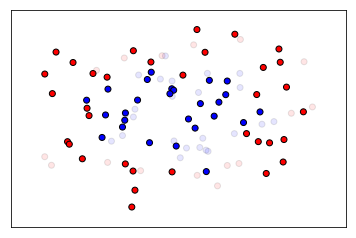

In [57]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = sklearn.datasets.make_circles(noise=0.2, factor=0.5, random_state=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
y_train = 2*y_train - 1
y_test = 2*y_test - 1
print('Number of training examples:', X_train.shape[0])
print('Number of test examples:', X_test.shape[0])

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# Plot the training points
ax = plt.subplot()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.1,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

In [58]:
def objective_plot(betas, K, y, lam, save_file=''):
    num_points = np.size(betas, 0)
    objs = np.zeros(num_points)
    for i in range(0, num_points):
        objs[i] = obj(betas[i, :], K, y, lam)
    fig, ax = plt.subplots()
    ax.plot(np.array(range(num_points)), objs, c='red')
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    plt.title('Objective value vs. iteration when lambda=' + str(lam))
    plt.show()

Now we're finally ready to try out our SVM code. We'll use a rule-of-thumb for the bandwidth of the RBF kernel. The rule-of-thumb says to use the median distance between all pairs of points in the training set.

sigma= 1.76530394456
Optimal betas: [ 0.01920469  0.01929564  0.01486229  0.01240471 -0.01650607 -0.02211181
 -0.01699633 -0.01715254  0.00383506 -0.00196752 -0.00849728  0.00845745
 -0.01161744 -0.01258793  0.00704191  0.01252946 -0.00721789  0.00071403
 -0.01703304  0.0167154  -0.00303515 -0.00922912  0.00423194  0.00631594
 -0.00653959  0.0141096  -0.01940402 -0.02099224  0.00196505  0.00020403
 -0.0063635   0.01004878 -0.01371631  0.00156944 -0.01776551 -0.00216482
  0.01660872  0.0221836  -0.01496385  0.01566578 -0.01489402 -0.02184029
  0.01555667 -0.00218452  0.01311845 -0.01726057  0.0001148  -0.02002571
  0.01642059 -0.01010292 -0.01719728 -0.0166169   0.00108974 -0.01032023
 -0.00137389 -0.01955894 -0.01739087  0.00448441  0.01822695  0.00757085]


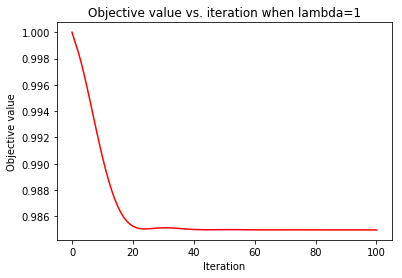

In [59]:
import scipy.linalg

# Initialize things
n, d = X_train.shape
lam = 1
beta_init = np.zeros(n)
theta_init = np.zeros(n)
dists = sklearn.metrics.pairwise.pairwise_distances(X_train).reshape(-1)
sigma = np.median(dists)
print('sigma=', sigma)
K = gram(X_train, X_train, sigma)
# Set eta_init based on an upper bound on the Lipschitz constant
eta_init = 1 / scipy.linalg.eigh(2 / n * np.dot(K, K) + 2 * lam * K, eigvals=(n - 1, n - 1),
                                 eigvals_only=True)[0]
maxiter = 100

# Run the algorithm
betas = fastgradalgo(beta_init, theta_init, K, y_train, lam, eta_init, maxiter)

# Examine results
print('Optimal betas:', betas[-1, :])
objective_plot(betas, K, y_train, lam, save_file='')

It looks like it works! Now what is the misclassification error, and what does the decision boundary look like?

** Exercise 8 ** Fill in the code below to compute the misclassification error. Recall that our prediction for a new point $x$ is $$\text{sign}\left(\sum_{i=1}^n \beta_ik(x_i, x)\right).$$

In [60]:
def misclassification_error(beta, X_train, X_test, y_test, kernel, **kwargs):
    n_test = len(y_test)
    y_pred = np.zeros(n_test)
    y_vals = np.zeros(n_test)
    # To do: Change the argument of range from 1 to the appropriate value
    for i in range(n_test):
        if 'sigma' in kwargs:
            sigma = kwargs['sigma']
            # To do: Compute sum(beta_ik(x_i, x)) using the kernel function from above.
            y_vals[i] = np.dot(kernel(X_train, X_test[i, :].reshape(1, -1), sigma).reshape(-1), beta)
        else:
            # To do: Copy the code from the previous part here, but without the sigma parameter. We'll use this
            # for the linear kernel later, which doesn't have a sigma parameter.
            y_vals[i] = np.dot(kernel(X_train, X_test[i, :].reshape(1, -1)).reshape(-1), beta)
    # To do: Take the sign of y_pred
    y_pred = np.sign(y_vals)
    return np.mean(y_pred != y_test), y_vals  # return error and values from before applying cutoff

Misclassification error when lambda = 1 : 0.125


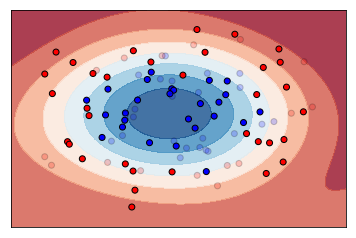

In [61]:
def evaluate(betas, gram, sigma=None):
    Zs = np.c_[xx.ravel(), yy.ravel()]
    if sigma:
        error, test_values = misclassification_error(betas[-1, :], X_train, X_test, y_test, gram, sigma=sigma)
        Z = misclassification_error(betas[-1, :], X_train, Zs, [0]*len(Zs), gram, sigma=sigma)[1]
    else:
        error, test_values = misclassification_error(betas[-1, :], X_train, X_test, y_test, gram)
        Z = misclassification_error(betas[-1, :], X_train, Zs, [0]*len(Zs), gram)[1]
    print('Misclassification error when lambda =', lam, ':', error)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax = plt.subplot()
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.2)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()
    
evaluate(betas, gram, sigma)

Note that the decision boundary is non-linear, as we would expect. Now let's compare to a non-kernel SVM. This is the same as using a kernel SVM with the linear kernel $K(x,y)=x^Ty$, so we can reuse our code from above and just modify the kernel.

** Exercise 9 ** Fill in the code below to compute the linear kernel. Test your code using the code from scikit-learn below.

In [47]:
def gram_linear(X, Z=None):
    """
    Inputs: 
    - X: matrix with observations as rows
    - Z: Another matrix with observations as rows
    Output: Gram matrix
    """  
    return X.dot(Z.T)

In [48]:
def test_gram():  
    np.random.seed(0)
    X = np.random.randn(6, 5)
    Z = np.random.randn(7, 5)
    sigma = 10
    gram1 = gram_linear(X, Z)
    gram2 = sklearn.metrics.pairwise.linear_kernel(X, Z)
    assert np.allclose(gram1, gram2), 'Computed matrix' + str(gram1) + 'does not match that of scikit-learn:' + str(gram2)
    print('Test passed')
    
test_gram()

Test passed


Now let's run the code again!

Optimal betas: [ -6.70986773e-05   7.60227289e-05   9.90558848e-05   1.39714384e-04
   2.74756092e-04  -4.80978440e-04   2.87215053e-04   4.83286071e-04
  -6.01364874e-05  -7.75181707e-05  -1.33731022e-04   8.77890839e-05
   8.75337158e-05   1.85099460e-05  -1.52000627e-04   2.01737630e-04
   3.44650652e-04   5.75817008e-05   5.51608978e-05  -2.68266398e-05
  -1.26705241e-04   3.77275893e-04  -2.20108035e-04  -2.10926208e-04
   9.15335287e-05  -9.28613312e-05   1.82417914e-04  -1.19681939e-04
  -1.96908380e-04   2.17881085e-04  -2.53984902e-04  -1.41773665e-04
  -2.42698288e-04   1.07220981e-04  -4.91073762e-04   3.10219734e-04
  -9.81495091e-06   3.09417822e-05  -3.76667354e-04   5.74779908e-05
   2.63238937e-04  -2.19029124e-04  -1.23314776e-04   3.44605462e-04
   1.95200159e-04  -8.45332677e-05   2.27846604e-05   5.81205304e-04
  -1.16947386e-04  -3.31176703e-04  -3.00697232e-04  -4.50149407e-04
   6.76977120e-05  -3.60719503e-04  -1.72133227e-04   3.56935185e-04
  -1.76555884e-04  

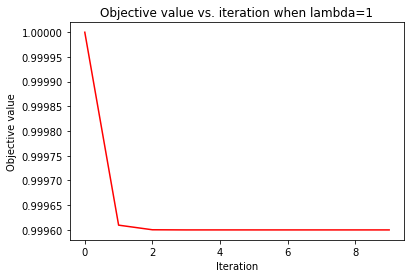

Misclassification error when lambda = 1 : 0.475


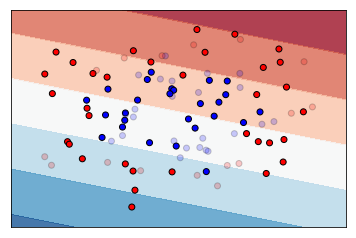

In [49]:
# Initialize things
n, d = X_train.shape
lam = 1
beta_init = np.zeros(n)
theta_init = np.zeros(n)
K = gram_linear(X_train, X_train)
eta_init = 1 / scipy.linalg.eigh(2 / n * np.dot(K, K) + 2 * lam * K, eigvals=(n - 1, n - 1),
                                 eigvals_only=True)[0]
maxiter = 10

# Run the algorithm
betas = fastgradalgo(beta_init, theta_init, K, y_train, lam, eta_init, maxiter)

# Examine results
print('Optimal betas:', betas[-1, :])
objective_plot(betas, K, y_train, lam, save_file='')
evaluate(betas, gram_linear, sigma=None)

Here the decision boundary is linear, which is clearly inappropriate for this data. Using a kernel SVM makes a big difference!

### 2.4 Real data example
Let's return to the Toucan vs. Hornbill example from Lab 3. Change `data_dir` below if necessary.

In [50]:
import numpy as np
import os

data_dir = 'lab3_data'

X_train = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
X_test = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test = np.load(os.path.join(data_dir, 'val_labels.npy'))

# Convert labels to +/- 1
y_train = 2*y_train - 1
y_test = 2*y_test - 1

In [51]:
print('Number of images:', X_train.shape[0])
print('Dimension of features:', X_train.shape[1])

Number of images: 1000
Dimension of features: 4096


We'll use fast gradient with the RBF kernel as above. Again, we'll use the rule of thumb for $\sigma$. It takes awhile for it to run, so I'll set the maximum number of iterations to 5000. Feel free to increase that value so it actually converges.

In [52]:
# Initialize things
n, d = X_train.shape
lam = .00001
beta_init = np.zeros(n)
theta_init = np.zeros(n)
dists = sklearn.metrics.pairwise.pairwise_distances(X_train).reshape(-1)
sigma = np.median(dists)
print('sigma =', sigma)
K = gram(X_train, X_train, sigma)
eta_init = 1 / scipy.linalg.eigh(2 / n * np.dot(K, K) + 2 * lam * K, eigvals=(n - 1, n - 1),
                                 eigvals_only=True)[0]
print('eta_init', eta_init)
maxiter = 5000

# Run the algorithm
print('Running fast gradient...')
betas = fastgradalgo(beta_init, theta_init, K, y_train, lam, eta_init, maxiter)
print('Done')

sigma = 117.186
eta_init 0.00136482948687
Running fast gradient...
Done


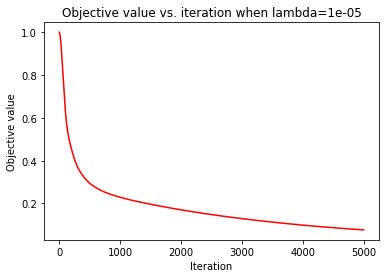

Accuracy: 0.9


In [53]:
# Examine results
objective_plot(betas, K, y_train, lam, save_file='')
error, scores = misclassification_error(betas[-1, :], X_train, X_test, y_test, gram, sigma=sigma)
print('Accuracy:', 1-error)

We did slightly better than in lab 3. Here though we didn't perform cross-validation. 

** Exercise 10* ** Perform cross-validation to choose $\sigma$ and $\lambda$. How do your results compare?

One downside to the kernel SVM is that its computational complexity is larger in terms of both training time and prediction time. In addition, if $n$ is very large, the Gram matrix can be prohibitively expensive to compute and/or store. There are ways around this that involve approximating the kernel. We unfortunately don't have time to cover these methods in this lab.